In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

In [ ]:
content_layer_num = 1
image_size = 512
epoch = 1000

In [ ]:
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 462 (delta 72), reused 190 (delta 65), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Deep-Learning-Paper-Review-and-Practice


In [ ]:
content_dir = "./code_practices/images/content_img_1.jpg"
style_dir = "./code_practices/images/style_img_1.jpg"

In [ ]:
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                        std=[1,1,1]),
                    #transforms.Normalize([0.5], [0.5])
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

In [ ]:
def image_postprocess(tensor):

    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    #transform = transforms.Normalize([0.5], [0.5])

    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

In [ ]:
resnet = models.resnet18(pretrained=True)

for name,module in resnet.named_children():
    print(name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.9MB/s]


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
class Resnet(nn.Module):

    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)

        return out_0, out_1, out_2, out_3, out_4, out_5

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet = Resnet().to(device)

for param in resnet.parameters():
    param.requires_grad = False    

In [ ]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [ ]:
content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)
#generated = torch.empty_like(content).uniform_(0, 1).to(device)



print(content.requires_grad,style.requires_grad,generated.requires_grad)

False False True


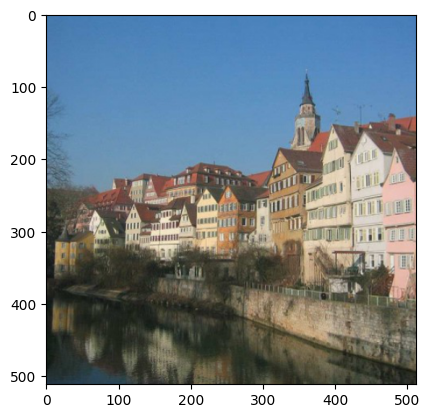

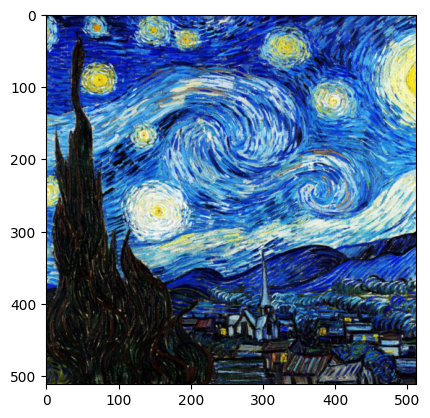

In [ ]:
plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

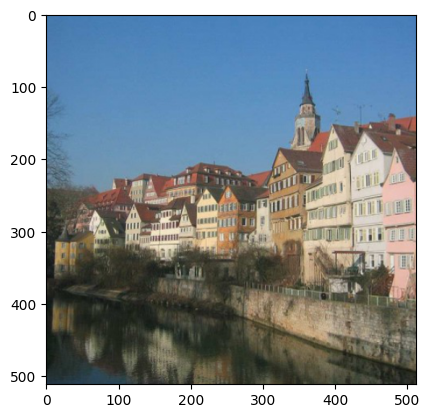

In [ ]:
gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.imshow(gen_img)
plt.show()

In [ ]:
style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

optimizer = optim.LBFGS([generated.requires_grad_()])

In [ ]:
iteration = [0]

while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)

        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)

        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
            gen_img = image_postprocess(generated[0].cpu()).data.numpy()    
            plt.imshow(gen_img)
            plt.show()
        iteration[0] += 1

        return total_loss

    optimizer.step(closure)